# Resumo de códigos utilizados no projeto.

 - Após as 3 semanas de desafio venho neste arquivo sintetizar os pontos chaves que marcaram o meu aprendizado e foram utilizados no projeto final.


Tratar dados para ML:

In [1]:
# Célula destinada ao Leitura e Tratamento dos dados que serão utilizados no modelo.

import pandas as pd
import seaborn as sns
import sqlalchemy as sql
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk

from sqlalchemy import create_engine

import matplotlib.backends.backend_pdf

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Conexão com o Banco de Dados.
string_connection = 'mysql+mysqlconnector://{user}:{password}@{server}/{database}'.format(
                    user='root',
                    password='125478',
                    server='127.0.0.1',
                    database='analise_risco')

cnx = sql.create_engine(string_connection)

# Leitura dos dados.
dados_raw = pd.read_sql('select * from analise_risco.dados_modelo_ml', cnx)
dados_raw = dados_raw.drop(columns=['tx_renda_divida'])

#-----------------------#

# Como ao final das analises percebemos que os dados nulos não tiveram influência na aprendizagem do modelo.
# Nesta linha deleto os dados nulos do dataset.
dados_raw.dropna(inplace = True)

# Porém fica abaixo uma função que pode ser utilizada para preencher os dados nulos.
def preenche_nulos(dados_raw):
    # Variaveis que devem ser excluídas.
    dados_raw.dropna(axis=0, subset=['vl_total'], inplace=True)
    dados_raw.dropna(axis=0, subset=['inadimplencia'], inplace=True)
    
    # Nas colunas que constam nesta lista.
    lista_groupby = ['pessoa_idade', 'salario_ano',
                    'ano_trabalhado', 'tx_juros', 'hst_inadimplencia']
    
    # Analisei que poderíamos conseguir estimar o dado nulo conforme mediana dos dados agrupados.
    for i in lista_groupby:
        dados_raw[i].fillna(dados_raw.groupby(['propriedade_sit', 'motivo_emprestimo'])[i].transform('median'), inplace=True)

# preenche_nulos(dados_raw)

dados = dados_raw.drop(columns=['pessoa_id'])

#-----------------------#

# Tratamento da Outliers das variáveis numéricas.
# As variaveis abaixo foram identificadas como outliers através de plotagens de boxplot.
# Também para julguei que para melhor aprendizagem do modelo, seria interessante criar faixas de valores para estas variáveis.

# Idade.
dados.drop(dados[dados["pessoa_idade"] > 86].index, inplace=True)

def criar_faixa_idade(dados):
    faixa_etaria = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
    faixa_etaria_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

    dados['faixa_idade'] = pd.cut(x=dados['pessoa_idade'], bins=faixa_etaria, labels=faixa_etaria_labels)
    dados['faixa_idade'] = dados['faixa_idade'].astype('int64')

    return dados

criar_faixa_idade(dados)

# Ano Trabalhado.
dados.drop(dados[dados["ano_trabalhado"] > 100].index, inplace=True)

# Valor do Emprestimo.
def criar_faixa_valor(dados):
    faixa_valor = [499, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 36000]
    faixa_valor_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70]

    dados['faixa_emprestimo'] = pd.cut(x=dados['vl_total'], bins=faixa_valor, labels=faixa_valor_labels)
    dados['faixa_emprestimo'] = dados['faixa_emprestimo'].astype('int64')
    return dados

criar_faixa_valor(dados)
#-----------------------#

#Gravar CSV para analise.

dados.to_csv('DATA/Dados.csv',sep= ";" ,index=False, encoding='utf-8')

#-----------------------#

# Separação da variável alvo.
x = dados.drop(columns=['inadimplencia'])
y = dados['inadimplencia']

#-----------------------#

# Tratamento das variáveis categóricas.

colunas_categoricas = ['propriedade_sit',
                       'motivo_emprestimo', 
                       'pontuacao_emprestimos']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     colunas_categoricas),
    remainder='passthrough')

x = one_hot_enc.fit_transform(x)
x = pd.DataFrame(x, columns=one_hot_enc.get_feature_names_out())

with open('MODELO/one_hot_enc.pkl', 'wb') as file:
    pk.dump(one_hot_enc, file)

#-----------------------#

#Normalizando os Dados.
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)

with open('Modelo/scaler.pkl', 'wb') as file:
    pk.dump(scaler, file)
#-----------------------#

Modelo

A Basse possui: 28,845 elementos.
----------------------------------------------------------------------------------------------------
A Basse foi rebalanceada com: SMOTE
************************************
Separada com: 31,637 elementos de treino e 13,559 elementos para teste.
----------------------------------------------------------------------------------------------------
Definição do Pipeline
----------------------------------------------------------------------------------------------------
MinMaxScaler()
****************
GradientBoostingClassifier(max_depth=8, max_features='sqrt', random_state=80,
                           subsample=0.85)
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      6731
         1.0       0.96      0.91      0.93      6828

  

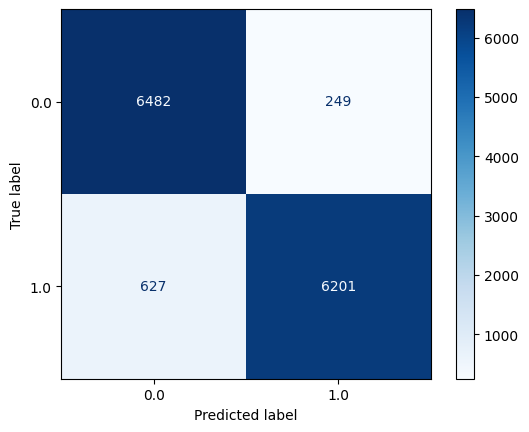

In [2]:
# Célula destinada a criação dos modelos de Machine Learning.

    # OBS: A avaliação dos modelos, parâmetros e otimização se encontram em outro notebook. {ValidarModelos.ipynb}

# Sampler para balanceamento dos dados - SMOTE.
# Separador Teste e Treino - Train Test Split.
# Modelo Escolhido - Gradient Boosting Classifier.

import numpy as np

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score

SEED = 80
np.random.seed(SEED)

print('A Basse possui: %s elementos.' % (x.shape[0].__format__(',d')))
print('-'*100)

# Balanceamento da Base de Dados.
resampler = SMOTE(random_state=SEED)
resampler_name = resampler.__getattribute__('__class__').__name__
x_resampled, y_resampled = resampler.fit_resample(x, y)

print('A Basse foi rebalanceada com: %s' % (resampler_name))
print('*'*36)

# Separação Treino e Teste.
treino_x, teste_x, treino_y, teste_y = train_test_split(x_resampled, y_resampled, test_size=0.30, random_state=0)

base_treino = treino_x.shape[0]
base_teste = teste_x.shape[0]

print('Separada com: %s elementos de treino e %s elementos para teste.' % (
    base_treino.__format__(',d'), base_teste.__format__(',d')))
print('-'*100)


scaler = MinMaxScaler()
modelo = GradientBoostingClassifier(loss='log_loss', max_depth=8, max_features='sqrt',
                                    random_state=80, subsample=0.85)


# Sugestão GridSearchCV
# GradientBoostingClassifier(criterion='squared_error', loss='exponential',
#                            max_depth=10, max_features='sqrt', random_state=80,
#                            subsample=0.618)


pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

predicao = pipeline.predict(teste_x)

dfpredicao = pd.DataFrame(predicao, columns=['predicao'])
dfpredicao.to_excel('Data/Previsao_TesteModelo.xlsx')

dfteste_x = pd.DataFrame(teste_x)
dfteste_x.to_excel('data/Teste_x.xlsx')

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]

print('roc_auc:', roc_auc_score(teste_y, prob_previsao))

matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')


with open('Modelo/modelo.pkl', 'wb') as file:
    pk.dump(pipeline, file)



# Modelar as requisições.

In [52]:
# Simulando Predições.

variaveis = {"pessoa_idade":20,
             "salario_ano": 10000,
             "propriedade_sit": "Própria",
             "ano_trabalhado": 1,
             "motivo_emprestimo": "Pessoal",
             "pontuacao_emprestimos": "G",
             "vl_total": 35000,
             "tx_juros": 11.14,
             "hst_inadimplencia": 0,
             "hst_primeiro_credito": 10}


df_pred = pd.DataFrame(variaveis, index=[0])

criar_faixa_idade(df_pred)

criar_faixa_valor(df_pred)

df_pred = one_hot_enc.transform(df_pred)
df_pred = pd.DataFrame(df_pred, columns=one_hot_enc.get_feature_names_out())

df_pred = scaler.transform(df_pred)

retorno = pipeline.predict(df_pred)

print(retorno)


[1.]


c:\Users\PauloVinicius\Documents\GitHub\AluraChallengeDataScience2\ambienteAluraChallengeDados\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
